<a href="https://colab.research.google.com/github/ventus550/HandwritingRecognition/blob/master/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [29]:
try:
    from google.colab import drive
    drive.mount('/content/mount', force_remount=False)
    %cd mount/MyDrive/MachineLearningProjects/HandwritingRecognition/notebooks
except ModuleNotFoundError: ...

Drive already mounted at /content/mount; to attempt to forcibly remount, call drive.mount("/content/mount", force_remount=True).
[Errno 2] No such file or directory: 'mount/MyDrive/MachineLearningProjects/HandwritingRecognition/notebooks'
/content/mount/MyDrive/MachineLearningProjects/HandwritingRecognition/notebooks


In [30]:
import os, sys
sys.path.append("..")

In [31]:
import keras
from keras.layers import *
import tensorflow as tf
%load_ext tensorboard

import numpy as np
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt

import utils

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Configuration

In [32]:
BASEDIR = Path().absolute().parent
DESTDIR = BASEDIR / "data"
MODLDIR = BASEDIR / "models"
DATASET = DESTDIR / "words.npz"

In [33]:
image_width = 128
image_height = 32
padding_token = 99
epochs = 1  # Should be at least 50

# Character codes
characters = [
	'!', '"', '#', '&', "'", '(', ')', '*', '+', ',',
	'-', '.', '/', '0', '1', '2', '3', '4', '5', '6',
	'7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D',
	'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
	'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
	'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
	'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
	's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]

## Load data

In [34]:
%%time
X, Y = np.load(DATASET).values()
maxlen = len(max(Y, key=len))
X = X.reshape([-1, image_height, image_width, 1])
Y = StringLookup(vocabulary=characters, num_oov_indices=0)(tf.strings.unicode_split(Y, input_encoding="UTF-8"))
Y = Y.to_tensor(default_value=padding_token, shape=(None, maxlen))

CPU times: user 632 ms, sys: 266 ms, total: 897 ms
Wall time: 1.01 s


In [35]:
X_test, Y_test	 = X[:1000], Y[:1000]
X_val, Y_val	 = X[1000:2000], Y[1000:2000]
X_train, Y_train = X[2000:], Y[2000:]

In [36]:
def ctc_loss(y_true, y_pred):
    batch_size = tf.cast(tf.shape(y_pred)[0], dtype=tf.int32)
    input_size = tf.cast(tf.shape(y_pred)[1], dtype=tf.int32)
    label_size = tf.cast(tf.shape(y_true)[1], dtype=tf.int32)
    input_size = tf.fill([batch_size, 1], input_size)
    label_size = tf.fill([batch_size, 1], label_size)
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_size, label_size)

In [37]:
def to_sparse_filtered(tensor, filtered_value, dtype=tf.int32) -> tf.SparseTensor:
    sparse = tf.cast(tf.sparse.from_dense(tensor), dtype=dtype)
    return tf.sparse.retain(sparse, tf.not_equal(sparse.values, filtered_value))


def edit_distance(y_true, y_pred):
    batch_size = tf.cast(tf.shape(y_pred)[0], dtype=tf.int32)
    input_size = tf.cast(tf.shape(y_pred)[1], dtype=tf.int32)
    input_size = tf.fill([batch_size], input_size)

    decode, log = keras.backend.ctc_decode(y_pred, input_length=input_size, greedy=True)
    sparse_truths = to_sparse_filtered(y_true, padding_token)
    sparse_decode = to_sparse_filtered(decode[0], -1)

    edit_distances = tf.edit_distance(sparse_decode, sparse_truths, normalize=False)
    return tf.reduce_mean(edit_distances)

In [38]:
namespace = tf.Graph()

def Convolutions(filters, kernel=5):
    return keras.models.Sequential([
        Conv2D(filters, kernel, padding='same', kernel_initializer="he_normal"),
        BatchNormalization(),
        Activation('relu')
    ], name=namespace.unique_name("convolutions"))


def build_model():
    input_img = keras.Input(shape=(image_height, image_width, 1), name="images")

    x = Permute([2, 1, 3])(input_img)

    x = Convolutions(32, 3)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Convolutions(64, 3)(x)
    x = MaxPooling2D((2, 2))(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), -1)
    x = Reshape(target_shape=new_shape)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)

    # RNNs.
    x = Bidirectional( LSTM(128, return_sequences=True, dropout=0.25) )(x)
    x = Bidirectional( LSTM(64, return_sequences=True, dropout=0.25) )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = Dense(len(characters) + 2, activation="softmax", name="predictions")(x)

    # Add CTC layer for calculating CTC loss at each step.
    # output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=input_img, outputs=x, name="handwriting_recognizer"
    )
    
    model.compile(optimizer="adam", loss=ctc_loss, metrics=[edit_distance])
    return model


model = build_model()

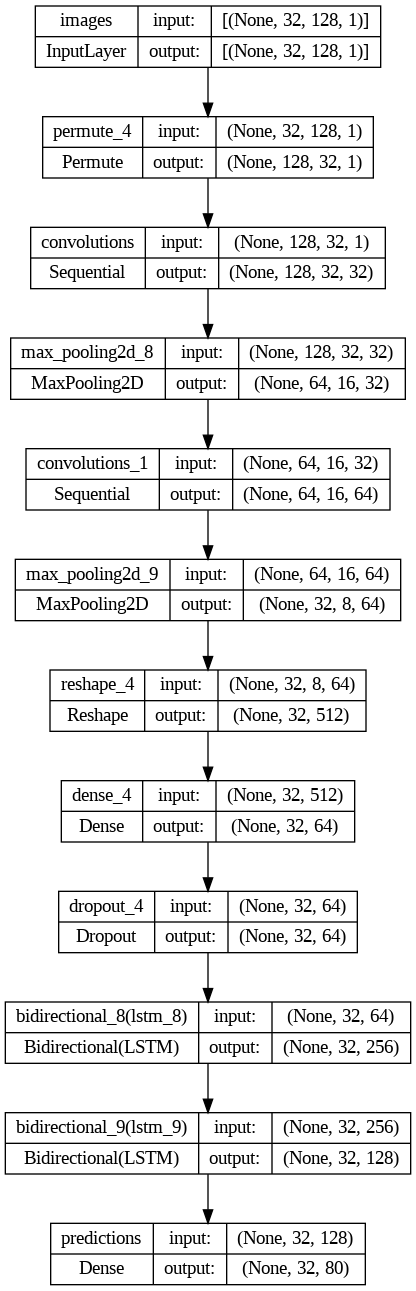

In [39]:
keras.utils.plot_model(model, show_shapes=1)

In [ ]:
model = build_model()

history = model.fit(
    X_train, Y_train,
    validation_data = (X_val, Y_val),
    epochs=epochs
)


 600/2952 [=====>........................] - ETA: 53s - loss: 14.6855 - edit_distance: 4.1532

In [ ]:
preds = model.predict(X_val[:12])
_, subs = plt.subplots(3, 4, figsize=(15, 4))
for img, pred, sb in zip(X_val[:12], preds[:12], subs.ravel()):
    sb.imshow(img, cmap="gray")
    sb.set_title(utils.ctc_decode(characters, pred))
    sb.axis("off")


In [ ]:
meta = {
    "epochs": epochs,
    "characters": "".join(characters),
    "padding": padding_token,
    "maxlen": maxlen
}

In [ ]:
utils.save(prediction_model, MODLDIR / "new.h5", metadata=meta)